<h1 style="font-size:2em;color:#2467C0">Importing libraries</h1>

In [1]:
import pandas as pd
import numpy as np
import random
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)#setting the plot size
plt.style.use('ggplot')
import joypy

<h1 style="font-size:2em;color:#2467C0">Data Loading</h1>

In [2]:
#Loading data from movies
movies=pd.read_csv('movielens/movies.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
#Loading data from ratings
ratings=pd.read_csv('movielens/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
#Loading data from tags
tags=pd.read_csv('movielens/tags.csv')
tags.tail()

,userId,movieId,tag,timestamp
465559,138446,55999,dragged,1358983772
465560,138446,55999,Jason Bateman,1358983778
465561,138446,55999,quirky,1358983778
465562,138446,55999,sad,1358983772
465563,138472,923,rise to power,1194037967


<h1 style="font-size:2em;color:#2467C0">Data Pre-processing</h1>

In [6]:
#data cleaning
movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [7]:
#data cleaning
ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [8]:
#data cleaning
tags.isnull().any()

userId       False
movieId      False
tag           True
timestamp    False
dtype: bool

In [9]:
#droping missing values
tags=tags.dropna()
tags.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [10]:
#extracting year from timestamp
ratings['year']=pd.to_datetime(ratings['timestamp'],unit='s').dt.year

ratings.head()

,userId,movieId,rating,timestamp,year
0,1,2,3.5,1112486027,2005
1,1,29,3.5,1112484676,2005
2,1,32,3.5,1112484819,2005
3,1,47,3.5,1112484727,2005
4,1,50,3.5,1112484580,2005


In [11]:
#dropping timestamp column
del ratings['timestamp']

ratings.head()

,userId,movieId,rating,year
0,1,2,3.5,2005
1,1,29,3.5,2005
2,1,32,3.5,2005
3,1,47,3.5,2005
4,1,50,3.5,2005


In [12]:
#extracting year from title in movies
movies['year']=movies['title'].str.extract('.*\((.*\d{4})\).*')

movies.head()


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [13]:
movies.isnull().any()

movieId    False
title      False
genres     False
year        True
dtype: bool

In [14]:
movies=movies.dropna()
movies.isnull().any()

movieId    False
title      False
genres     False
year       False
dtype: bool

In [15]:
#making sure all values in column year are correctly formatted.
movies[movies.year.str.len()!=4]

,movieId,title,genres,year
22679,108583,Fawlty Towers (1975-1979),Comedy,1975-1979


In [16]:
movies=movies.drop(22679)

<h1 style="font-size:2em;color:#2467C0">Data exploration</h1>

In [17]:
#checking range of years:
print('Ratings data has been collected over years of: ',ratings['year'].min(), ' to ', ratings['year'].max(),'.')

Ratings data has been collected over years of:  1995  to  2015 .


In [18]:
#how many genres are there?
print('There are {} genres in movies data.'.format(len(movies.genres.unique().tolist())))

There are 1342 genres in movies data.


In [19]:
#There are more than one rating for each movie.
print('There are:',len(ratings.movieId.unique().tolist()), 'unique movieId in ratings.')

There are: 26744 unique movieId in ratings.


In [20]:
#exploring genres
movies.genres.unique().tolist()[200:210]

['Adventure|Animation|Children|Musical',
 'Adventure|Drama|Romance|War',
 'Comedy|Musical|Romance',
 'Musical|Romance',
 'Comedy|Musical',
 'Action|Adventure|Mystery|Romance|Thriller',
 'Comedy|Crime|Mystery|Romance|Thriller',
 'Film-Noir|Mystery',
 'Comedy|Drama|Musical|Romance',
 'Musical']

In [21]:
#frequency of genres in movies set
movies['genres'].value_counts()[100:110]


Comedy|War                 33
War                        32
Drama|Mystery|Romance      32
Romance|Western            32
Adventure|Sci-Fi           31
Comedy|Drama|War           31
Mystery                    31
Children|Comedy|Fantasy    30
Action|Horror              30
Action|Horror|Thriller     30
Name: genres, dtype: int64

<h1 style="font-size:2em;color:#2467C0">Data visualization</h1>

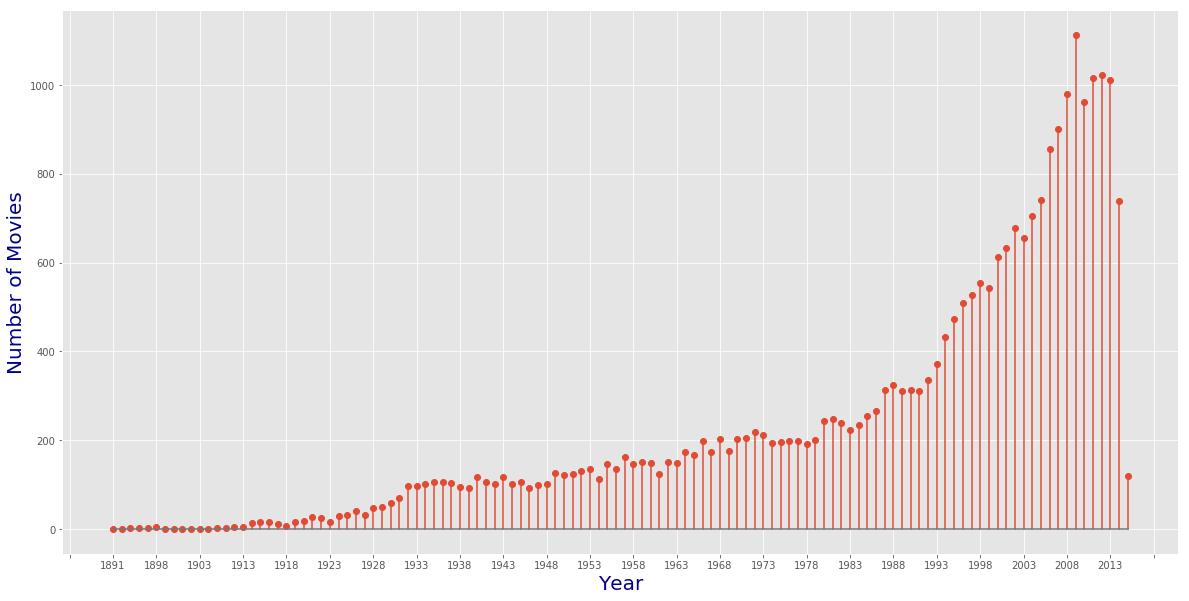

In [22]:
#Number of movies produced over the years

tick_spacing = 5
fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


all_movies=movies[['title','year']].groupby('year').count()
plt.stem(all_movies.index,all_movies['title'])
plt.xlabel('Year',fontsize=20,color='darkblue')
plt.ylabel('Number of Movies',fontsize=20,color='darkblue')
#plt.legend('Movies Production Trend',loc='upper left')
plt.savefig('all_movies_per_year_trend.png')
plt.show()

**As we can see, there is a boom in film production industry after 90's. There is no doubt that the technological advancement and the internet have had a big contribution in this increase.**

In [23]:
#a function to filter movies by genre
def filter_by_genre(movies, genre):
    """
    Return movies of a specific/filtered genre
    """
    return movies[movies.genres.str.contains(genre)]

In [24]:
#grouping and counting number of movies per year an
def plot_count(data,genre):
    """
    Return a DataFrame with year as index and count of title per year.
    DataFrame renamed to reflect genre
    """
    movies_per_year=(data[['title','year']].groupby('year').count())
    movies_per_year.columns=[genre]
    return movies_per_year
    

Let's add the average rating of movie to DataFrame

In [25]:
average_rating = ratings[['movieId','rating']].groupby('movieId').mean().round(1)
#average_rating=average_rating.set_index('movieId')
average_rating.tail()

,rating
movieId,
131254,4.0
131256,4.0
131258,2.5
131260,3.0
131262,4.0


In [26]:
average_rating.shape[0]

26744

In [27]:
movies_with_rating=movies[movies['year']>'1900'].merge(average_rating,on='movieId',how='inner')
movies_with_rating.head()

,movieId,title,genres,year,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.9
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.2
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.2
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.9
4,5,Father of the Bride Part II (1995),Comedy,1995,3.1


In [28]:
#filtering movies based on genres and grouping them for plotting

list_genres=['Drama','Comedy','Romance','Animation','Documentary','Sci-Fi','Action']#list of genre we are interested in
data_movies=[]#a list of filtered movies data

for movie in list_genres:#iterating over list of genres and saving them in movies list
    data_movies.append((filter_by_genre(movies_with_rating,movie)))

data_movies[0].head()



,movieId,title,genres,year,rating
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.9
10,11,"American President, The (1995)",Comedy|Drama|Romance,1995,3.7
13,14,Nixon (1995),Drama,1995,3.4
15,16,Casino (1995),Crime|Drama,1995,3.8
16,17,Sense and Sensibility (1995),Drama|Romance,1995,4.0


In [32]:
genre_data=[]
for i in range(len(data_movies)):
    genre_data.append(plot_count(data_movies[i],list_genres[i]))

genre_data[0].tail()

,Drama
year,
2011,467
2012,429
2013,427
2014,301
2015,36


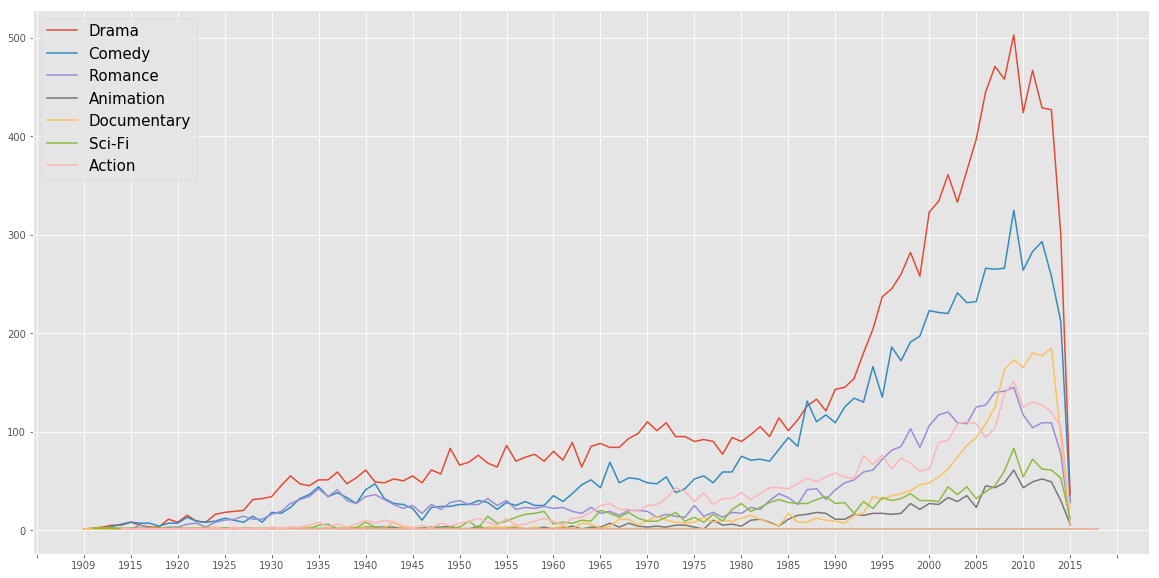

In [33]:
tick_spacing = 5
fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


for data in genre_data:
    plt.plot(data, label=str(data.columns[0]),)
    plt.legend(loc='upper left',fontsize=15)

plt.savefig('genres_per_year_trend.png')

In [34]:
data_movies[0].head()

,movieId,title,genres,year,rating
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.9
10,11,"American President, The (1995)",Comedy|Drama|Romance,1995,3.7
13,14,Nixon (1995),Drama,1995,3.4
15,16,Casino (1995),Crime|Drama,1995,3.8
16,17,Sense and Sensibility (1995),Drama|Romance,1995,4.0


In [35]:
genres_ratings=dict()

for i in range(len(data_movies)):
    genres_ratings[list_genres[i]]=data_movies[i].rating


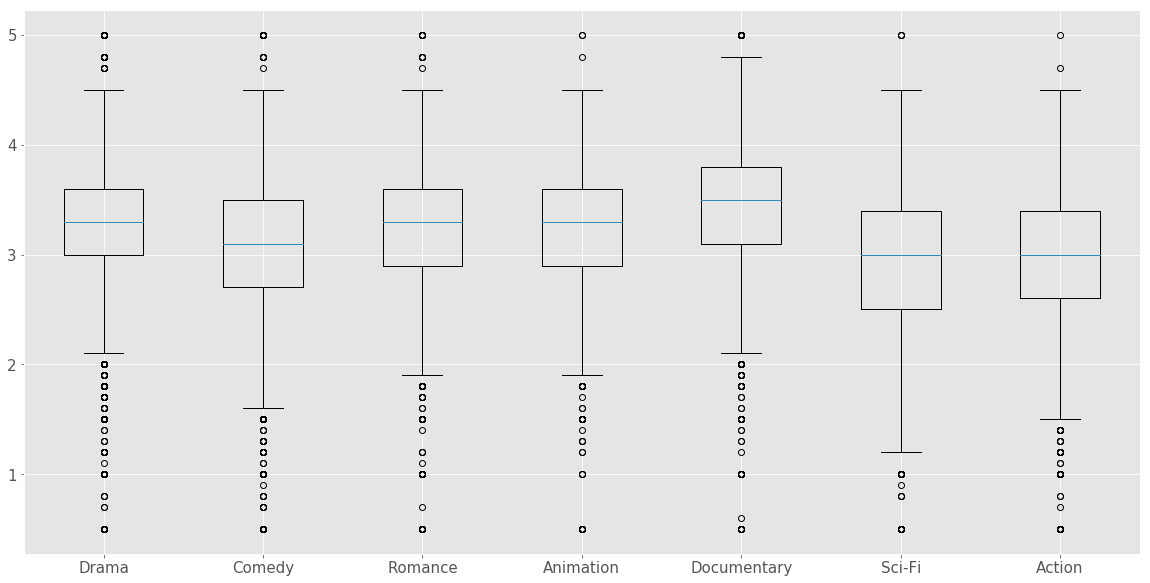

In [57]:
fig, ax = plt.subplots(figsize=(20,10))

label_of_plot,data_box_plot=genres_ratings.keys(),genres_ratings.values()
plt.boxplot(data_box_plot)
plt.xticks(range(1, len(label_of_plot) + 1), label_of_plot, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('average ratings')
plt.show()

In [60]:
#grouping and getting average of rating of each genre for each year
def plot_average(data,genre):

    """
    Return a DataFrame with year as index and average rating of each genre per year.
    DataFrame renamed to reflect genre name
    """
    average_rating=(data[['rating','year']].groupby('year').mean().round(1))
    average_rating.columns=[genre]
    return average_rating
    

In [61]:
#prepating the data stucture for plotting
rating_data=[]
for i in range(len(data_movies)):
    rating_data.append(plot_average(data_movies[i],list_genres[i]))

rating_data[2].sort_values('year').head()

,Romance
year,
1914,3.3
1915,3.0
1916,3.0
1917,3.2
1918,3.3


In [62]:
len(rating_data)

7

In [63]:
type(rating_data[0])

pandas.core.frame.DataFrame

In [64]:
rating_col_0=rating_data[0].columns
rating_col_0


Index(['Drama'], dtype='object')

In [65]:
three_popular=rating_data[:4]#drama,comdedy,romance

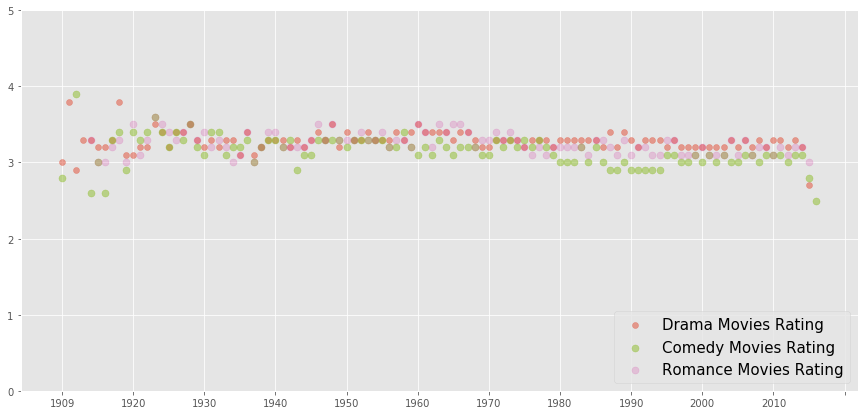

In [67]:
# rating of movies,average per year
fig, ax = plt.subplots(figsize=(15,7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))


plt.scatter(rating_data[0].index,rating_data[0].Drama,alpha=0.5,label='Drama Movies Rating')
plt.scatter(x=rating_data[1].index,y=rating_data[1].Comedy,color='#8DBC28',s=50,alpha=0.5,label='Comedy Movies Rating')
plt.scatter(x=rating_data[2].index,y=rating_data[2].Romance,color='#D32B9E',s=50,alpha=0.2,label='Romance Movies Rating')
#plt.ylabel('Rating',fontsize=15,color='#004A7E')
plt.ylim(0,5)
plt.legend(loc='lower right',fontsize=15)
plt.savefig('scatter_rating.png')

In [68]:
data_movies[4].head()

,movieId,title,genres,year,rating
36,37,Across the Sea of Time (1995),Documentary|IMAX,1995,3.0
76,77,Nico Icon (1995),Documentary,1995,3.4
97,99,Heidi Fleiss: Hollywood Madam (1995),Documentary,1995,3.1
106,108,Catwalk (1996),Documentary,1996,3.1
114,116,Anne Frank Remembered (1995),Documentary,1995,3.9


No handles with labels found to put in legend.


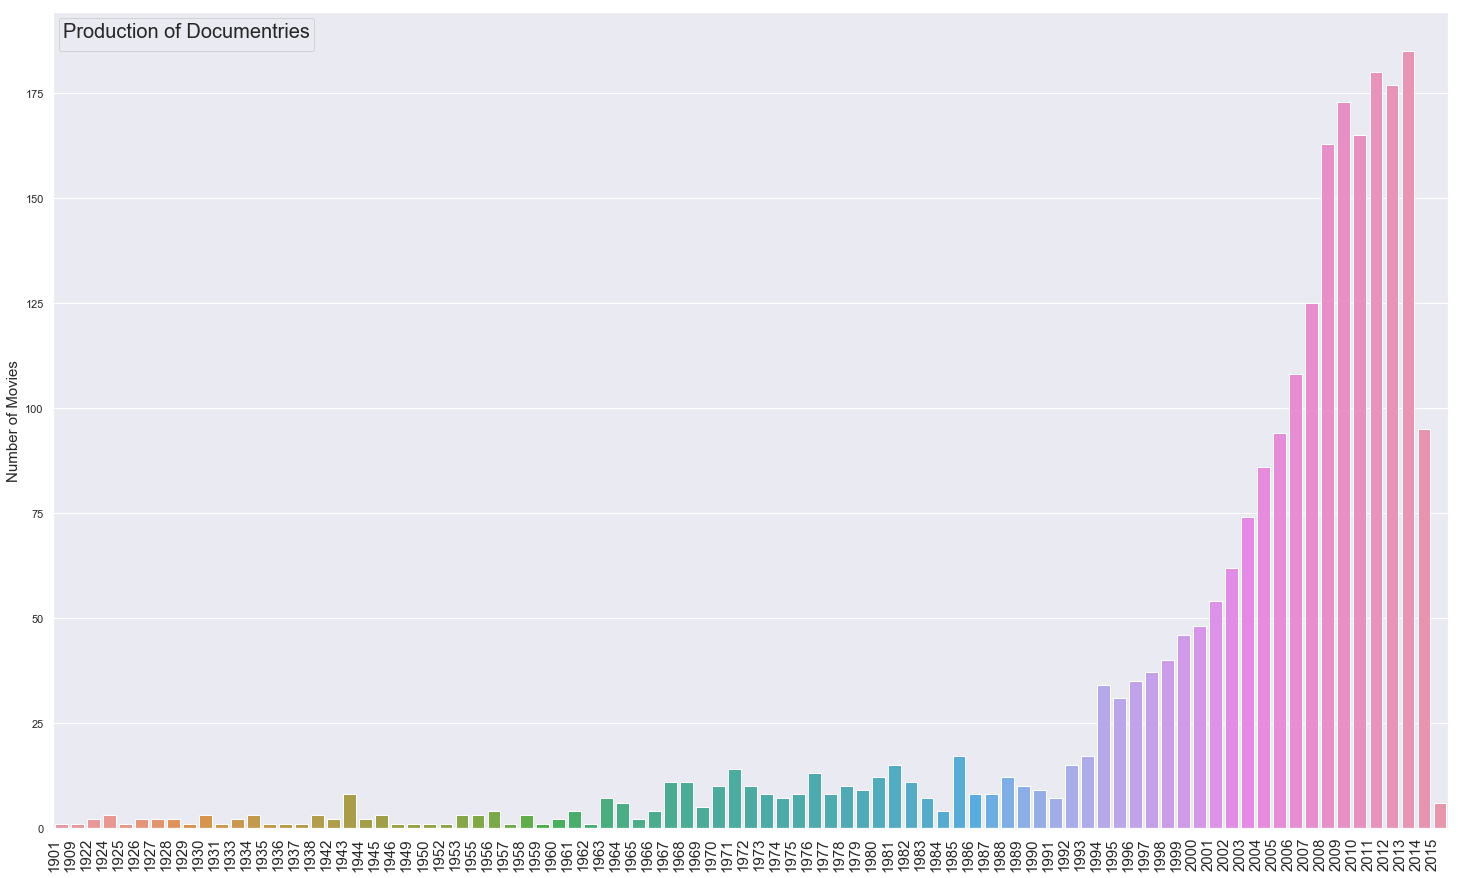

In [69]:
#documentry movies production
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(25,15))

ax = sns.countplot(x="year", data=data_movies[4])

ax.set_xticklabels(ax.get_xticklabels(),fontsize=15,rotation=90, ha="right")
ax.set_xlabel('')
ax.set_ylabel('Number of Movies',fontsize=15)

plt.legend(title='Production of Documentries',title_fontsize=20,loc='upper left')
plt.savefig('documentries_production.png')
plt.show()

**Looking at the trend of documentry movies, we might be able to say that the age of information and internet is showing its impact on factual movies. Documentries are a great way to eduacate people and impact the society.** 

In [70]:
#Let's explore the most common tags users have utilized to describe a movie
tag_counts=tags['tag'].value_counts()
tag_counts[:10]

sci-fi             3384
based on a book    3281
atmospheric        2917
comedy             2779
action             2657
surreal            2427
BD-R               2334
twist ending       2323
funny              2072
dystopia           1991
Name: tag, dtype: int64

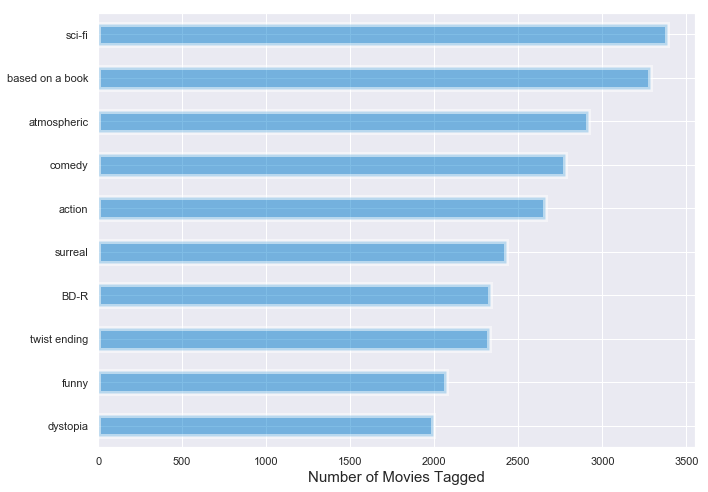

In [71]:
tag_counts[:10].plot(kind='barh', figsize=(10,7),color='#007acc', alpha=0.5, linewidth=5)
plt.gca().invert_yaxis()
plt.xlabel('Number of Movies Tagged',fontsize=15)
plt.tight_layout()
plt.savefig('genres_tags_popular.png')

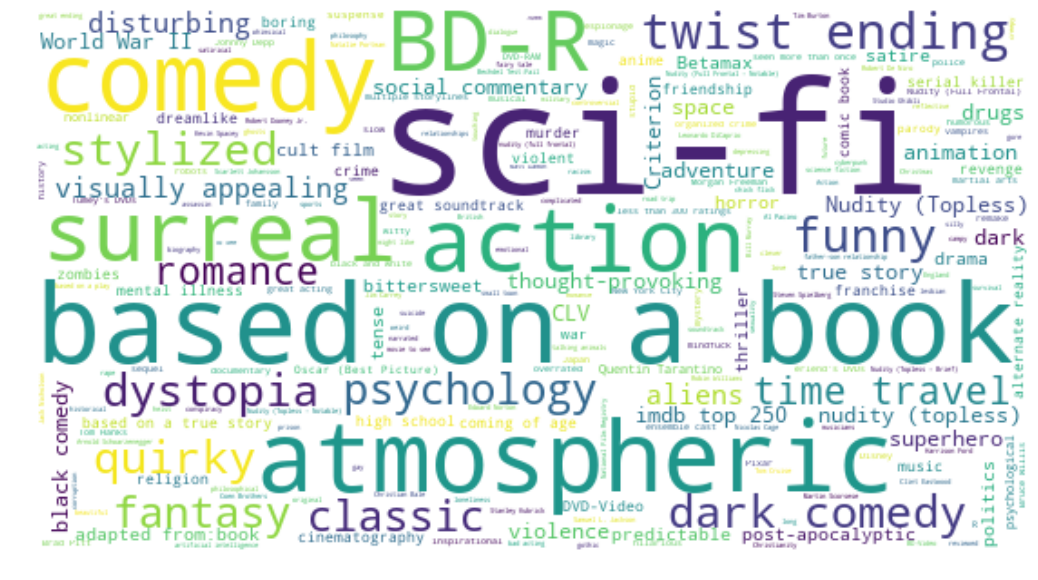

In [72]:
#creating a word cloud based on frequenct of tags

words = dict(tag_counts)

f, ax = plt.subplots(figsize=(20, 10))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.savefig('wordcloud.png')
plt.show()

#### As we saw before, Sci-Fi movies are among the most frequent used tag for in tags dataset.